## Script to load in a processed seurat object and run pySCENIC

To get your processed Seurat object into adata format you can use conversion functions, such as:
```r
#load custom functions
source("./customFunctions.R")

#load in processed R data and subset on OCs
seu.obj <- readRDS(file = "../output/s3/dc_QCfiltered_2000_res0.3_dims35_dist0.3_neigh50_S3.rds")


#stash new idents
Idents(seu.obj) <- "clusterID_sub"
seu.obj <- RenameIdents(seu.obj, c("0" = "cDC2", "1" = "mregDC", 
                                   "2" = "cDC1", "3" = "pDC",
                                   "4" = "preDC")
                       )
seu.obj$majorID_sub <- Idents(seu.obj)

Idents(seu.obj) <- "clusterID_sub"
seu.obj <- RenameIdents(seu.obj, c("0" = "cDC2 (c0)", "1" = "mregDC (c1)", 
                                   "2" = "cDC1 (c2)", "3" = "pDC (c3)",
                                   "4" = "preDC (c4)")
                       )
seu.obj$majorID_sub2 <- Idents(seu.obj)

cnts <- seu.obj@assays$RNA@counts
cnts <- orthogene::convert_orthologs(gene_df = cnts,
                                        gene_input = "rownames", 
                                        gene_output = "rownames", 
                                        input_species = "dog",
                                        output_species = "human",
                                        non121_strategy = "drop_both_species") 
rownames(cnts) <- unname(rownames(cnts))

seu.obj <- CreateSeuratObject(cnts, project = "humanConvert", assay = "RNA",
                                  min.cells = 0, min.features = 0, names.field = 1,
                                  names.delim = "_", meta.data = seu.obj@meta.data)

seu.obj <- NormalizeData(seu.obj)

SaveH5Seurat(seu.obj, filename = "../output/s3/dc_hu.h5Seurat")
Convert("../output/s3/dc_hu.h5Seurat", dest = "h5ad")

```

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from matplotlib.pyplot import rc_context
from MulticoreTSNE import MulticoreTSNE as TSNE
from pyscenic.export import export2loom, add_scenic_metadata

import seaborn as sns
import matplotlib.pyplot as plt
import scipy 

import glob

import json
import zlib
import base64

In [18]:
FIGURES_FOLDERNAME="../output/scenic/"
def savesvg(fname: str, fig, folder: str=FIGURES_FOLDERNAME) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format='svg')

In [4]:
#load in the data
adata = sc.read_h5ad("../output/s3/dc_hu.h5ad")
adata

AnnData object with n_obs × n_vars = 1067 × 12928
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.hbm', 'percent.ppbp', 'RNA_snn_res.0.1', 'seurat_clusters', 'int.clusID', 'pANN_0.25_0.14_157', 'DF.classifications_0.25_0.14_157', 'doublet', 'S.Score', 'G2M.Score', 'Phase', 'clusters', 'nCount_SCT', 'nFeature_SCT', 'pANN_0.25_0.005_142', 'DF.classifications_0.25_0.005_142', 'pANN_0.25_0.005_172', 'DF.classifications_0.25_0.005_172', 'pANN_0.25_0.13_168', 'DF.classifications_0.25_0.13_168', 'pANN_0.25_0.04_209', 'DF.classifications_0.25_0.04_209', 'pANN_0.25_0.005_94', 'DF.classifications_0.25_0.005_94', 'pANN_0.25_0.16_79', 'DF.classifications_0.25_0.16_79', 'pANN_0.25_0.12_96', 'DF.classifications_0.25_0.12_96', 'integrated_snn_res.0.8', 'clusterID', 'orig.ident_2', 'majorID', 'freqID', 'id', 'tumorO', 'intID', 'name', 'colz', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'clusterID_final', 'integrated_snn_res.0.6', 'clusterID_sub', 'majorID_sub', 'integrated

In [5]:
#convert from numeric to string
anno = adata.obs
anno['majorID_sub2'] = anno.majorID_sub2.astype(str)
adata.obs = anno

In [6]:
#convert index to gene symbol
tempAdata = adata.raw.to_adata()
tempAdata.var_names = adata.var['features']
adata.raw = tempAdata

In [ ]:
#cant run b/c UMAP coords weren't brought over
# sc.pl.umap(adata, color=['IGHM','majorID_sub2','name'], use_raw = False)

In [7]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( "../output/s3/dc_hu.loom", adata.X.transpose(), row_attrs, col_attrs)

The easiest way to run the code is to use a sbatch script, so generate a script with:

In [12]:
!echo "#!/usr/bin/env bash" > cute_pyScenic_grn.sbatch
!echo "#SBATCH --job-name=pySCENIC_grn" >> cute_pyScenic_grn.sbatch

!echo "#SBATCH --nodes=1" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --ntasks=16" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --time=00:30:00" >> cute_pyScenic_grn.sbatch

!echo "#SBATCH --partition=atesting" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --qos=normal" >> cute_pyScenic_grn.sbatch

!echo "#SBATCH --mail-type=END" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --mail-user=dyammons@colostate.edu" >> cute_pyScenic_grn.sbatch
!echo "#SBATCH --output=pySCENIC_grn-%j.log" >> cute_pyScenic_grn.sbatch

!echo "" >> cute_pyScenic_grn.sbatch

!echo "#load conda env" >> cute_pyScenic_grn.sbatch
!echo "source /curc/sw/anaconda3/latest" >> cute_pyScenic_grn.sbatch
!echo "conda activate scPy" >> cute_pyScenic_grn.sbatch

!echo "" >> cute_pyScenic_grn.sbatch

!echo "#call cmd" >> cute_pyScenic_grn.sbatch
!echo "pyscenic grn ../output/s3/dc_hu.loom \\" >> cute_pyScenic_grn.sbatch
!echo "./metaData/allTFs_hg38.txt \\" >> cute_pyScenic_grn.sbatch
!echo "-o ../output/scenic/adj.csv \\" >> cute_pyScenic_grn.sbatch
!echo "--num_workers \$SLURM_NTASKS" >> cute_pyScenic_grn.sbatch

In [13]:
#submit the job
!sbatch cute_pyScenic_grn.sbatch

Submitted batch job 4297216


In [14]:
!echo "#!/usr/bin/env bash" > cute_pyScenic_ctx.sbatch
!echo "#SBATCH --job-name=pySCENIC_ctx" >> cute_pyScenic_ctx.sbatch

!echo "#SBATCH --nodes=1" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --ntasks=10" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --time=00:20:00" >> cute_pyScenic_ctx.sbatch

!echo "#SBATCH --partition=amilan" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --qos=normal" >> cute_pyScenic_ctx.sbatch

!echo "#SBATCH --mail-type=END" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --mail-user=dyammons@colostate.edu" >> cute_pyScenic_ctx.sbatch
!echo "#SBATCH --output=pySCENIC_ctx-%j.log" >> cute_pyScenic_ctx.sbatch

!echo "" >> cute_pyScenic_ctx.sbatch

!echo "#load conda env" >> cute_pyScenic_ctx.sbatch
!echo "source /curc/sw/anaconda3/latest" >> cute_pyScenic_ctx.sbatch
!echo "conda activate scPy" >> cute_pyScenic_ctx.sbatch

!echo "" >> cute_pyScenic_ctx.sbatch

!echo "pyscenic ctx ../output/scenic/adj.csv \\" >> cute_pyScenic_ctx.sbatch
!echo "./metaData/hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather ./metaData/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather \\" >> cute_pyScenic_ctx.sbatch
!echo "--annotations_fname ./metaData/motifs-v9-nr.hgnc-m0.001-o0.0.tbl \\" >> cute_pyScenic_ctx.sbatch
!echo "--expression_mtx_fname ../output/s3/dc_hu.loom \\" >> cute_pyScenic_ctx.sbatch
!echo "--output ../output/scenic/reg.csv \\" >> cute_pyScenic_ctx.sbatch
!echo "--mask_dropouts \\" >> cute_pyScenic_ctx.sbatch
!echo "--num_workers \$SLURM_NTASKS" >> cute_pyScenic_ctx.sbatch


In [15]:
#submit the job; took 8 min....
!sbatch cute_pyScenic_ctx.sbatch

Submitted batch job 4297413


In [16]:
!echo "#!/usr/bin/env bash" > cute_pyScenic_aucell.sbatch
!echo "#SBATCH --job-name=pySCENIC_auc" >> cute_pyScenic_aucell.sbatch

!echo "#SBATCH --nodes=1" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --ntasks=4" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --time=0:10:00" >> cute_pyScenic_aucell.sbatch

!echo "#SBATCH --partition=amilan" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --qos=normal" >> cute_pyScenic_aucell.sbatch

!echo "#SBATCH --mail-type=END" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --mail-user=dyammons@colostate.edu" >> cute_pyScenic_aucell.sbatch
!echo "#SBATCH --output=pySCENIC_auc-%j.log" >> cute_pyScenic_aucell.sbatch

!echo "" >> cute_pyScenic_aucell.sbatch

!echo "#load conda env" >> cute_pyScenic_aucell.sbatch
!echo "source /curc/sw/anaconda3/latest" >> cute_pyScenic_aucell.sbatch
!echo "conda activate scPy" >> cute_pyScenic_aucell.sbatch

!echo "" >> cute_pyScenic_aucell.sbatch

!echo "pyscenic aucell \\" >> cute_pyScenic_aucell.sbatch
!echo "../output/s3/dc_hu.loom \\" >> cute_pyScenic_aucell.sbatch
!echo "../output/scenic/reg.csv \\" >> cute_pyScenic_aucell.sbatch
!echo "--output ../output/scenic/dc_hu_scenic_output.loom \\" >> cute_pyScenic_aucell.sbatch
!echo "--num_workers \$SLURM_NTASKS" >> cute_pyScenic_aucell.sbatch

In [17]:
#took 2 min....
!sbatch cute_pyScenic_aucell.sbatch

Submitted batch job 4297819


In [10]:
# collect SCENIC AUCell output
lf = lp.connect("../output/scenic/dc_hu_scenic_output.loom", mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [11]:
auc_mtx

,AHR(+),AHRR(+),ARID3A(+),ARID5A(+),ARNT(+),ATF1(+),ATF2(+),ATF3(+),ATF4(+),ATF6(+),...,ZNF384(+),ZNF408(+),ZNF41(+),ZNF410(+),ZNF449(+),ZNF569(+),ZNF76(+),ZNF768(+),ZNF786(+),ZNF789(+)
AAGACTCAGCTTCTAG-1_1,0.069260,0.0,0.061355,0.024768,0.039990,0.032475,0.180137,0.060669,0.061204,0.018014,...,0.026502,0.0,0.0,0.0,0.0,0.0,0.019860,0.000000,0.008320,0.000000
AAGTACCGTCGCCACA-1_1,0.144962,0.0,0.070349,0.012225,0.045472,0.035249,0.209060,0.061878,0.089749,0.016269,...,0.026788,0.0,0.0,0.0,0.0,0.0,0.023607,0.000000,0.000000,0.000000
AATCACGCAATCCTTT-1_1,0.105613,0.0,0.054067,0.013773,0.034120,0.030718,0.219977,0.052047,0.052029,0.017605,...,0.026865,0.0,0.0,0.0,0.0,0.0,0.017890,0.000000,0.000000,0.000000
AATGACCGTTTCCAAG-1_1,0.109857,0.0,0.050892,0.044812,0.046053,0.035346,0.219733,0.056306,0.070791,0.019577,...,0.017794,0.0,0.0,0.0,0.0,0.0,0.015779,0.024187,0.000000,0.029154
AATTCCTAGTTCGGTT-1_1,0.046739,0.0,0.063061,0.018219,0.018124,0.037756,0.194965,0.037664,0.075266,0.014251,...,0.027314,0.0,0.0,0.0,0.0,0.0,0.019772,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCATGTTCGTTGTGA-1_8,0.149106,0.0,0.062010,0.000000,0.022446,0.043061,0.232606,0.054520,0.101421,0.027788,...,0.030395,0.0,0.0,0.0,0.0,0.0,0.014741,0.000000,0.076238,0.008514
TTCCAATAGCCAGTAG-1_8,0.110806,0.0,0.063761,0.019528,0.063919,0.041949,0.198387,0.054678,0.097489,0.014068,...,0.017732,0.0,0.0,0.0,0.0,0.0,0.018875,0.000000,0.000000,0.000000
TTCTTCCCACTGGCGT-1_8,0.127634,0.0,0.041694,0.000000,0.034249,0.034435,0.175656,0.048825,0.092745,0.036848,...,0.023135,0.0,0.0,0.0,0.0,0.0,0.038823,0.000000,0.097910,0.000000
TTGGATGGTCGCTGCA-1_8,0.104664,0.0,0.069987,0.033302,0.028186,0.036305,0.191788,0.066483,0.104418,0.032083,...,0.024474,0.0,0.0,0.0,0.0,0.0,0.023994,0.000000,0.000000,0.000000


In [12]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
# from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [13]:
cellAnnot = pd.concat(
    [
        pd.DataFrame( adata.obs.index.tolist(), index=adata.obs['majorID_sub2'].tolist() )
    ],
    axis=1
)
cellAnnot.columns = [
 'majorID_sub2']


In [14]:
rss = regulon_specificity_scores(auc_mtx, adata.obs.majorID_sub2)
rss.head()

,AHR(+),AHRR(+),ARID3A(+),ARID5A(+),ARNT(+),ATF1(+),ATF2(+),ATF3(+),ATF4(+),ATF6(+),...,ZNF384(+),ZNF408(+),ZNF41(+),ZNF410(+),ZNF449(+),ZNF569(+),ZNF76(+),ZNF768(+),ZNF786(+),ZNF789(+)
0,0.650866,0.229460,0.605467,0.563866,0.587272,0.588271,0.616565,0.628880,0.578118,0.580478,...,0.583391,0.248060,0.229465,0.172942,0.215088,0.201131,0.559076,0.302066,0.283711,0.263292
2,0.253879,0.175480,0.309364,0.315750,0.289048,0.310812,0.306394,0.291889,0.298409,0.301901,...,0.302700,0.202339,0.195244,0.167445,0.186845,0.178576,0.296634,0.222419,0.202104,0.208986
3,0.202352,0.183682,0.233145,0.208452,0.257089,0.227728,0.222065,0.224304,0.239783,0.251885,...,0.232717,0.226834,0.270823,0.167445,0.220620,0.246112,0.249259,0.189441,0.193374,0.214925
1,0.299586,0.185342,0.303977,0.271078,0.276339,0.323085,0.301137,0.299180,0.338277,0.307134,...,0.327546,0.267432,0.220121,0.220417,0.193433,0.192027,0.346524,0.350303,0.258934,0.217769
4,0.220785,0.175120,0.222771,0.194419,0.233668,0.226586,0.223213,0.220884,0.227884,0.224754,...,0.216494,0.184789,0.206263,0.167445,0.200621,0.167445,0.222912,0.193613,0.200171,0.207122


In [15]:
rss = rss.rename(index={'0' : 'cDC2',
                        '1' : 'mregDC',
                        '2' : 'cDC1',
                        '3' : 'pDC',
                        '4' : 'preDC'})

In [16]:
pd.DataFrame.to_csv(rss, "../output/scenic/dc_rss.csv")

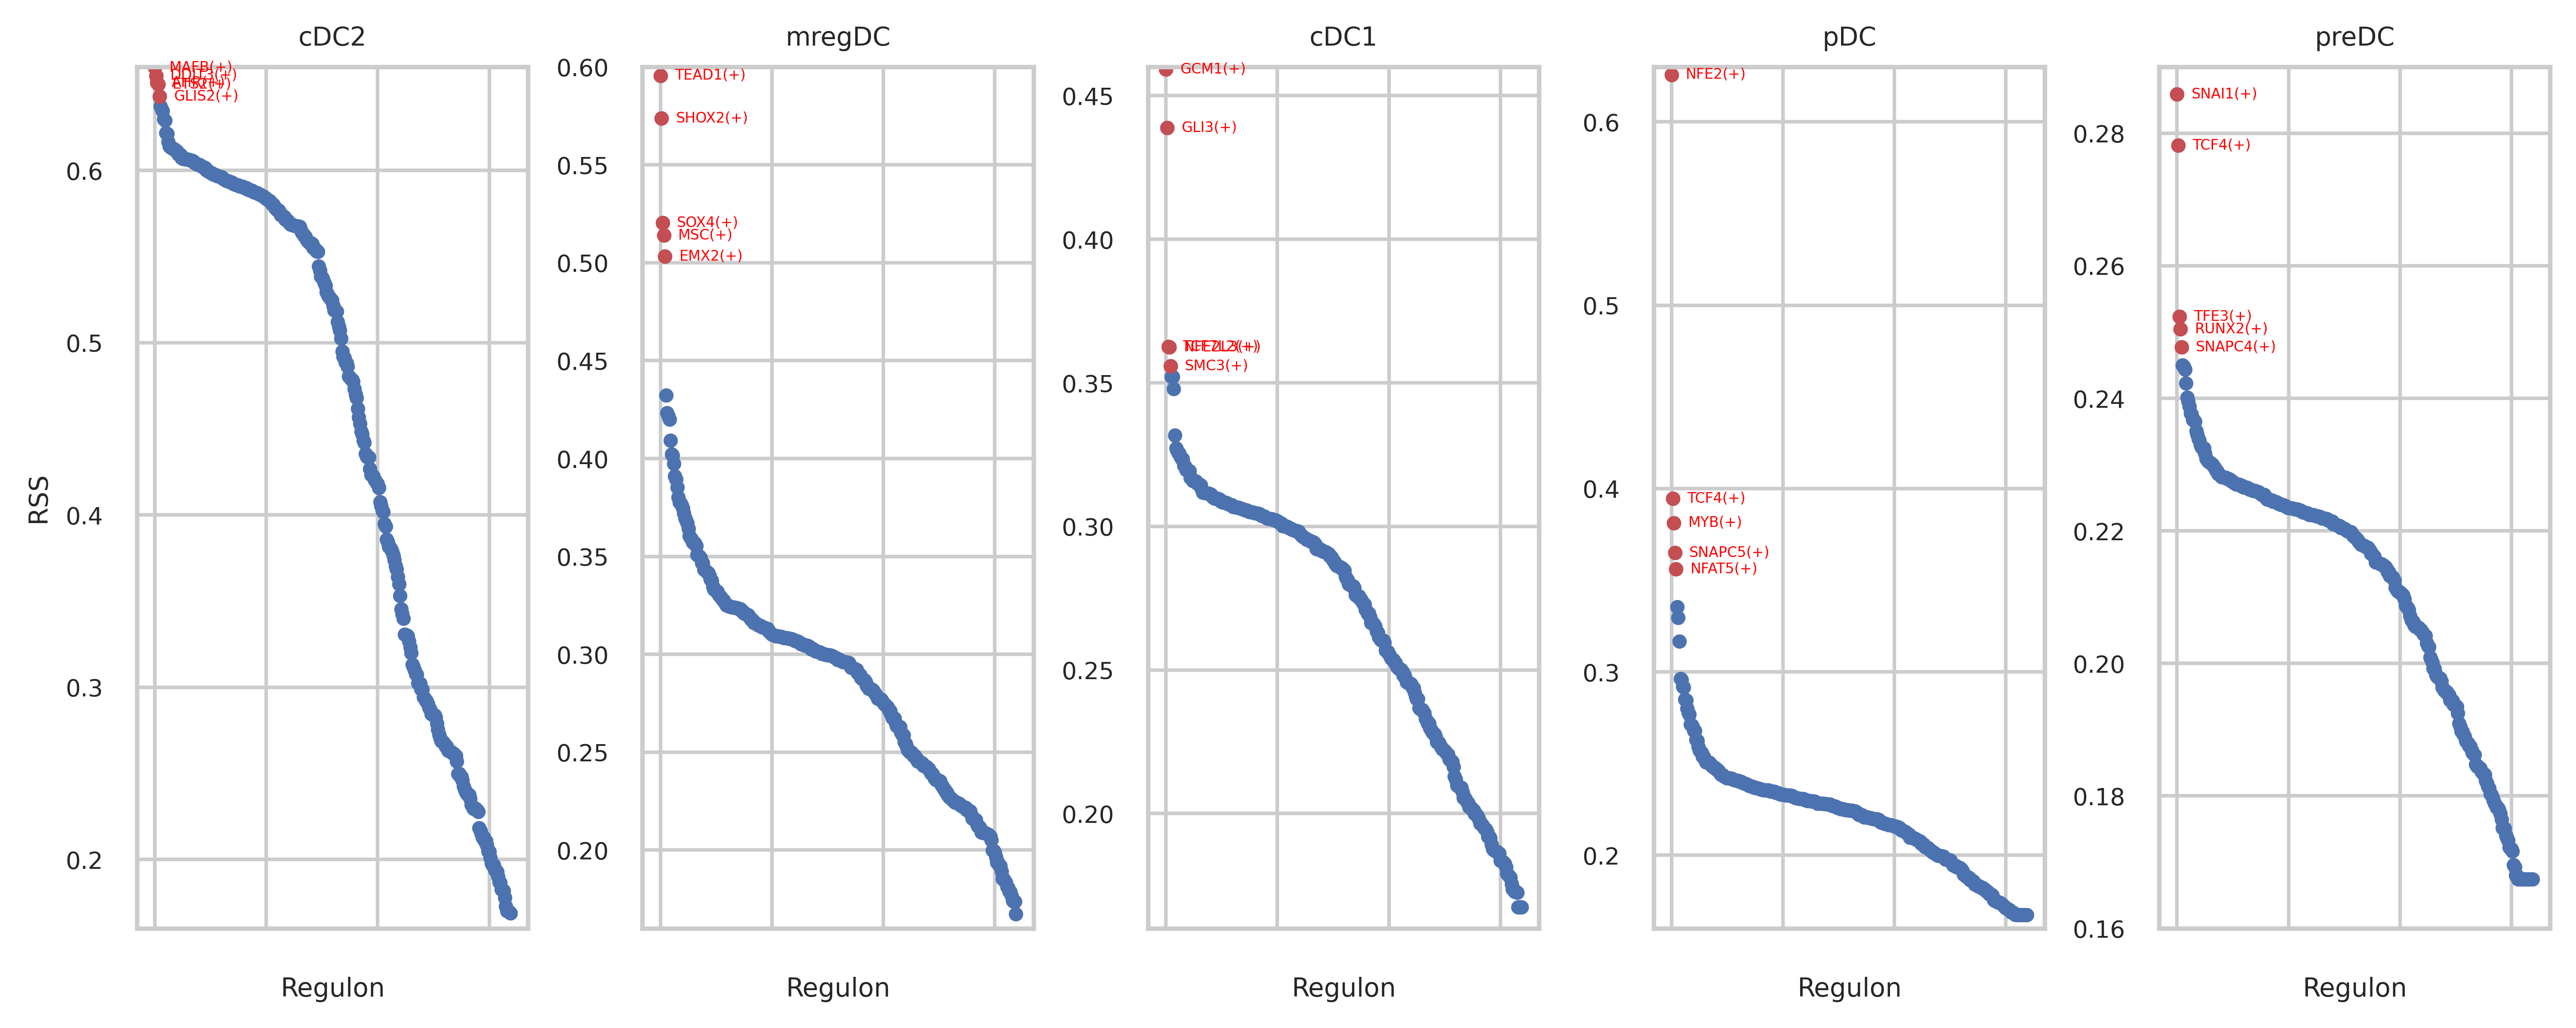

In [21]:
sns.set()
sns.set(style='whitegrid', font_scale=0.6)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(10, 4), dpi=600)
plot_rss(rss, 'cDC2', ax=ax1)
plot_rss(rss, 'mregDC', ax=ax2)
ax2.set_ylabel('')
plot_rss(rss, 'cDC1', ax=ax3)
ax3.set_ylabel('')
plot_rss(rss, 'pDC', ax=ax4)
ax4.set_ylabel('')
plot_rss(rss, 'preDC', ax=ax5)
ax5.set_ylabel('')
savesvg('rss.svg', fig)


```r
df <- read.csv("../output/scenic/dc_rss.csv", row.names = 1)
colnames(df) <- gsub('\\.\\.\\.',"",colnames(df))
df.all <- t(df) %>% as.data.frame() %>% rownames_to_column()

labCut = 10
pi <- lapply(2:ncol(df.all), function(x){
    #prep data
    celltype <- colnames(df.all)[x]
    df <- df.all[ ,c("rowname",celltype)] 
    colnames(df) <- c("gene", "clus")
    df <- df %>% arrange(desc(clus))
    df[ ,"gene"] <- factor(df[ ,"gene"], levels = df[ ,"gene"])
    df <- df %>% mutate(colz = ifelse(row_number() < labCut+1, "#FF6961", "lightblue"),
                        labz = ifelse(row_number() < labCut+1, as.character(gene), NA))
    
    #plot the data
    p <- ggplot(df, aes(x = gene, y = clus, label = labz)) +
    geom_point(colour = df$colz, size = 2) + 
    geom_text_repel(
        force = 0.01,
        nudge_x = nrow(df)*0.5,
        direction = "y",
        seed = 42, 
        box.padding = 0.25,
        #hjust = 0,
        #segment.size = 0.2, 
        size = 4, 
        color = df$colz,
        max.iter = 100000000,
        max.overlaps = 10
    ) + 
    labs(
        title = celltype,
        x = "Regulon",
        y = "rss"
    ) + 
    theme_classic() + 
    theme(
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        panel.border = element_blank(),
        plot.margin = unit(c(10, 10, 10, 10), "pt"),
        panel.background = element_rect(fill = "transparent",colour = NA),
        plot.background = element_rect(fill = "transparent",colour = NA),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank()
    ) + 
    scale_y_continuous(
        breaks = function(y) {
            seq(floor(min(y, digits = 1)), 
            ceiling(max(y, digits = 1)), 
            by = 0.1)
        }
    ) + coord_cartesian(expand = TRUE, clip = "off")

    #return/save plot
    ggsave(paste0("../output/scenic/", gsub(" ", "_", celltype), "_rss.png"), height = 5, width = 3)
    return(p)
})


p <- Reduce( `+`, pi) + plot_layout(ncol = 5)
ggsave(plot = p, "../output/scenic/dc_rss.png", height = 4, width = 12)

```